[View in Colaboratory](https://colab.research.google.com/github/3catz/time_series_LSTMS/blob/master/Ionosphere_Time_Series_Forecasting_with_EMD_and_Convolutional_Neural_Networks.ipynb)

# Ionosphere Time Series Analysis using Empirical Mode Decomposition and Convolutional Neural Networks

Magnetic field time series, n = 4000. We use a lookback window of 20, the last 20 values, in order to predict the next time step in its decomposed form. Since EMD is a form of additive decomposition, we can reconstruct the signal and make a forecast by adding the various components together. However, since we can only do data analysis on what data we have, we do the EMD process knowing full well that the results of that process can differ depending not only the particular parameters and methods that are used in the sifting, but also by the existence of more data. Long-term trends and dynamics won't appear until we have sufficient data, so there are things we miss out on, however, we do EMD knowing that this is all that we have until we collect more data. 

In [0]:
!pip install pyhht
!pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#import pandas_datareader.data as web
from pandas import Series
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint
#keras
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.engine.topology import Layer
import peakutils
#!pip install pyramid-arima
#from pyramid.arima import auto_arima

# Utilities: series to supervised, attention with context

In [0]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
   

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis = -1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]



# Loading Data 

In [0]:
from google.colab import files    
files.upload()




In [0]:
import numpy as np  
data = np.fromfile(".dat", sep = "\n")
print(data)
len(data)


In [0]:
data = np.genfromtxt("SPIDR11300.csv", delimiter = ","); data = np.asarray(data)

In [5]:
data.shape

(4000,)

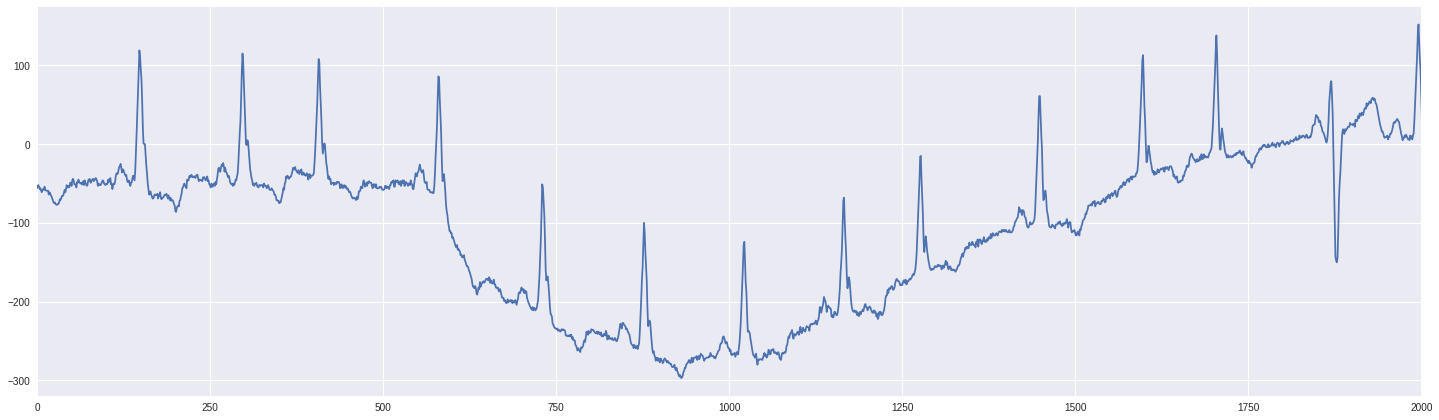

In [6]:
#Plot that sucker (at least some of it)
from scipy.interpolate import interp1d 
plt.figure(figsize=(20,6))
plt.plot(data)
plt.tight_layout()
plt.xlim([0,2000])
plt.show()

In [7]:
print(np.min(data), np.max(data))


-297.0 152.0


In [8]:
#Scale the Data
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(4000,)

In [0]:
scaled_data = np.transpose(scaled_data)

In [0]:
# before you do the EMD, cut out the out of sample part so that the EMDs are not constructed with those future values and information contained within them

in_sample = scaled_data[:-1000]; out_sample = scaled_data[-1000:]

#Empirical Mode Decomposition


In [11]:
from pyhht.emd import EMD 
from pyhht.visualization import plot_imfs

decomposer1 = EMD(in_sample,  maxiter = 10000)
imfs1 = decomposer1.decompose()
len(imfs1)

Mode 6, Iteration 3000
1 minima > 0; 96 maxima < 0.


11

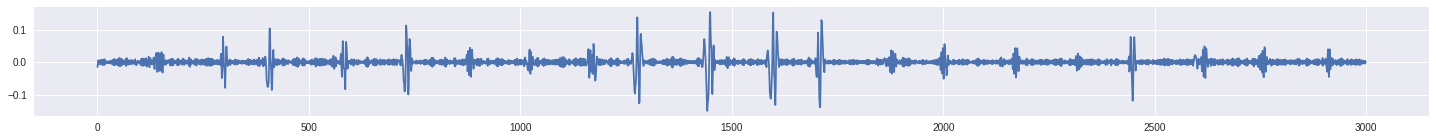

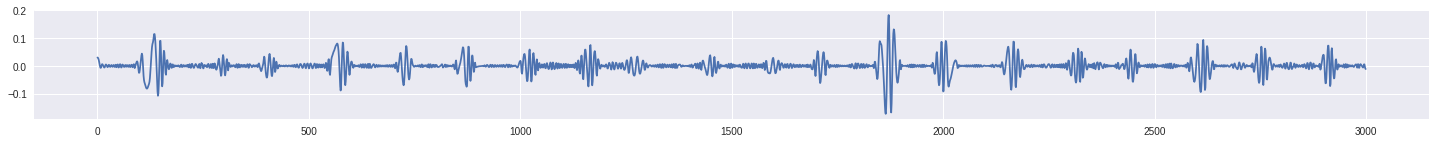

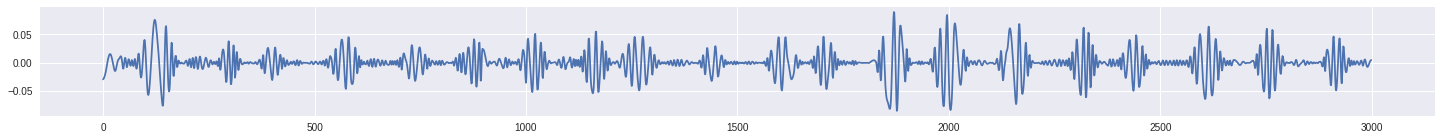

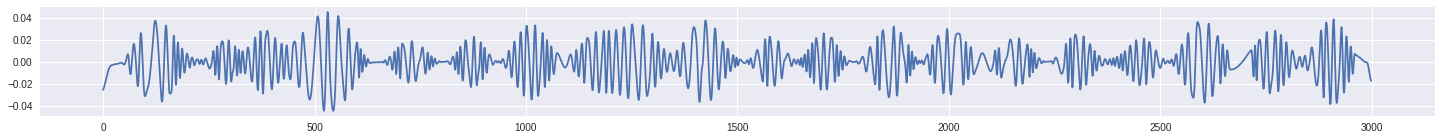

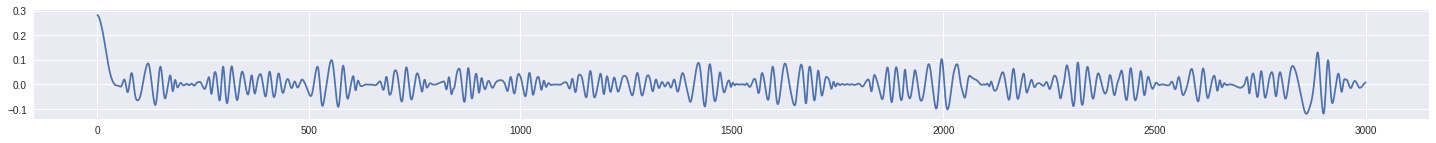

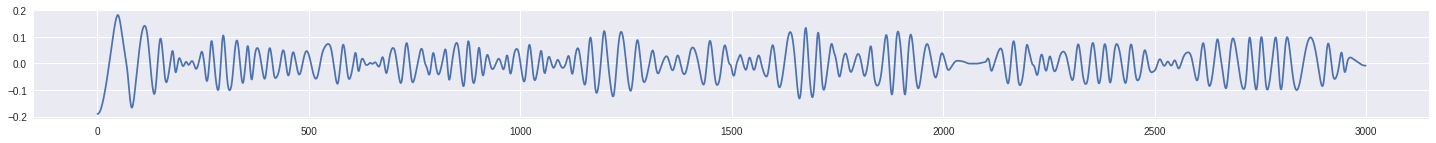

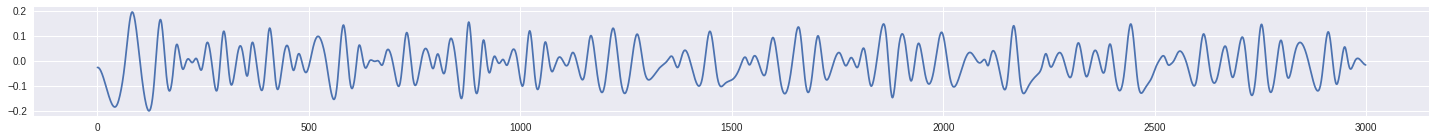

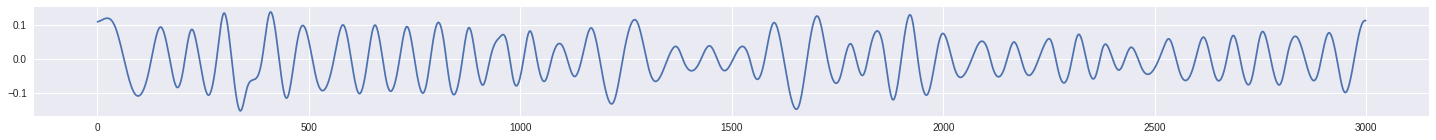

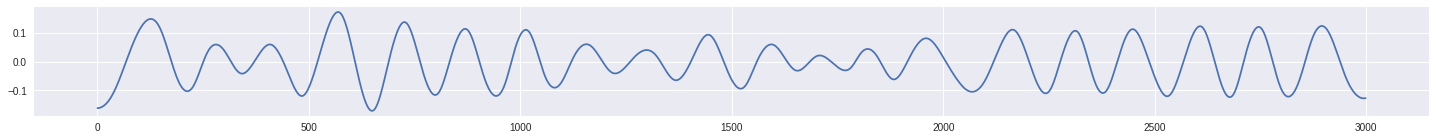

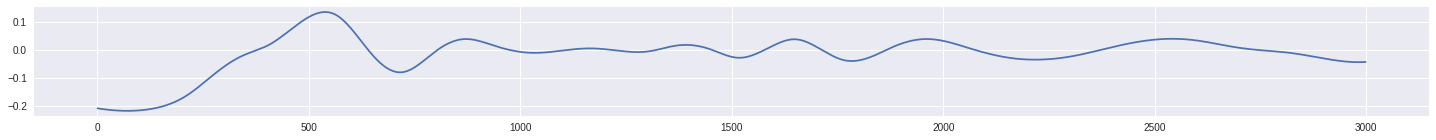

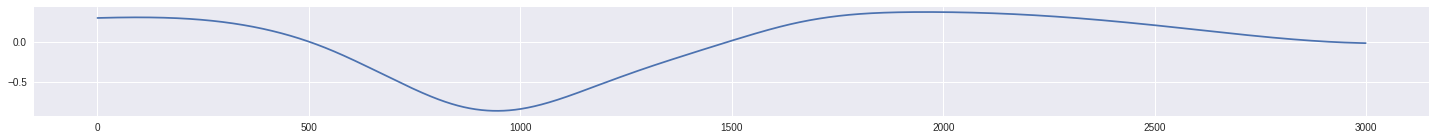

In [12]:
for i in range(len(imfs1)):
  fig, ax = plt.subplots(figsize=(25,2))
  fig = plt.plot(imfs1[i])
  plt.show()

# Creating Datasets


*Raw Data, using lags = 20*

In [13]:
in_sample = in_sample.reshape(-1,1); print(in_sample.shape)

(3000, 1)


In [0]:
lookback = 20
data_f = series_to_supervised(in_sample, n_in = lookback, n_out = 1, dropnan = True)

In [15]:
# this is the raw data, broken into sequences of 20 that result in sequence of 1.
print(data_f.shape)
data_f = np.asarray(data_f)
Xr = data_f[:,:-1]
Y = data_f[:,-1]
print(Xr.shape, Y.shape)

(2980, 21)
(2980, 20) (2980,)


In [0]:
#trainXr, validXr = train_test_split(Xr, test_size = 0.25, shuffle = False)
validXr, testXr = train_test_split(validXr, test_size = 0.5, shuffle = False)
trainXr = np.expand_dims(trainXr, axis = 1)
validXr = np.expand_dims(validXr, axis = 1)
testXr = np.expand_dims(testXr, axis = 1)

In [181]:
#print(trainXr.shape, validXr.shape, testXr.shape)

(2235, 1, 20) (372, 1, 20) (373, 1, 20)


# All IMFs

In [16]:
imfs1.shape
imfs1 = np.transpose(imfs1, (1,0)); imfs1.shape

(3000, 11)

In [17]:
imf_df = series_to_supervised(imfs1, n_in = lookback, n_out = 1, dropnan = True)
imf_df = np.expand_dims(imf_df, axis = 1)
print(imf_df.shape)

(2980, 1, 231)


In [18]:
imf_df = np.reshape(imf_df, (imf_df.shape[0],21,11))

print(imf_df.shape)


(2980, 21, 11)


In [19]:
# in that (21,17) tensor, the 17 values are the target meaning you after the 20 time steps goes by you get the (1,17) decomped signal
#so you want imf_df[:,-1,:]
targets = imf_df[:,-1,:]
print(targets.shape)

(2980, 11)


In [20]:
print(Xr.shape) #make sure this is right 
#in essence you are starting with a 20-ple (the last 20 values) and then teaching it the next value in terms of the 17-tuple decomp.
#so start with 20 and end up with 17.
# its a temporal model so you need (20,1) ie 20 time steps leading to (1,17) which is 1 time step and 17 features.

(2980, 20)


In [21]:
#so reshape everything properly
input_data = np.reshape(Xr, (targets.shape[0],1,lookback))
targets = np.reshape(targets,(targets.shape[0],1,targets.shape[1]))
print(input_data.shape, targets.shape)

(2980, 1, 20) (2980, 1, 11)


In [0]:
# OUT sample EMD and get it in shape 

decomposer2 = EMD(out_sample,  maxiter = 20000)
out_imfs = decomposer2.decompose()
print(out_imfs.shape)
out_imfs = np.transpose(out_imfs, (1,0)); print(out_imfs.shape)
#out_imfs = np.expand_dims(out_imfs, axis = 1)
print(out_imfs.shape)

(8, 1000)
(1000, 8)
(1000, 8)


In [0]:
test_df = series_to_supervised(out_imfs, n_in = lookback, n_out = 0, dropnan = True)
print(test_df.shape)
test_df = np.expand_dims(test_df, axis = 1)
print(test_df.shape)
#Reshaping into 3d tensor 
#testX = np.reshape(test_df,(980,20,3))
#print(testX.shape)
#print(testX.shape)

In [191]:
#test Y values 

out_df = series_to_supervised(out_sample.reshape(-1,1), n_in = 20, n_out = 1, dropnan = True)
print(out_df.shape); out_df = np.asarray(out_df)
testY = out_df[:,-1]
testX = out_df[:,:-1]

testX = np.expand_dims(testX, axis = 1)
print(testX.shape,testY.shape)

(980, 21)
(980, 1, 20) (980,)


# Partial autocorrelation 

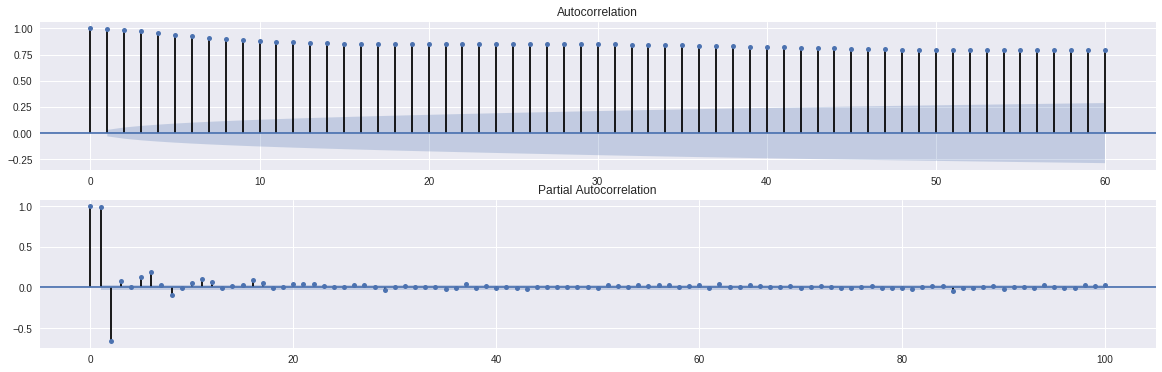

In [147]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(2, figsize=(20,6))
fig1 = plot_acf(scaled_data,lags = 60, ax = axes[0])
fig2 = plot_pacf(scaled_data, lags = 100, ax = axes[1])
plt.show()

# Network Architecture and Model fitting 

In [22]:
from keras.layers.advanced_activations import *
from keras.regularizers import l1, l2 
from sklearn.metrics import r2_score
import keras.backend as K
from keras.layers import ConvLSTM2D
from keras.layers import LeakyReLU
np.random.seed(2018) #inputs are (1, 20) and outputs are #(1 time step,17 features)

inputs = Input(shape = (1,20))

x = Conv1D(128, 3, padding = "causal", dilation_rate = 1)(inputs)
y = Conv1D(128, 3, padding = "causal", dilation_rate = 4)(inputs)
z = Conv1D(128, 3, padding = "causal", dilation_rate = 8)(inputs)
a = Conv1D(128, 3, padding = "causal", dilation_rate = 16)(inputs)
b = Conv1D(128, 3, padding = "causal", dilation_rate = 32)(inputs)
c = Conv1D(256, 3, padding = "causal", dilation_rate = 64)(inputs)
d = Conv1D(256, 3, padding = "causal", dilation_rate = 128)(inputs)

z = concatenate([inputs, x, y, z, a, b, c, d], axis = -1)
z = LeakyReLU()(z)
z = LSTM(11,return_sequences = True)(z)

predictions = LSTM(11, activation = "tanh", return_sequences = True,
                   dropout = 0, recurrent_dropout = 0.1,
                   kernel_initializer = "he_normal"
                   )(z)


model = Model(inputs = inputs, outputs = predictions)
opt = adam(lr = 1e-3, clipnorm = 1.)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor = 0.9, patience = 3, min_lr = 1e-5, verbose = 1)
checkpointer = ModelCheckpoint(filepath = "timeseries_weights.hdf5", verbose = 1, save_best_only = True)
early = EarlyStopping(monitor = 'loss', min_delta = 1e-5, patience = 30, verbose = 1)

model.compile(optimizer=opt, loss='mse', metrics = [])
model.summary()

history = model.fit(input_data, targets, 
          epochs = 20, 
          batch_size = 128, 
          verbose = 1, 
          #validation_data = (validX, validY),
          callbacks = [reduce_lr, early],
          shuffle = False)  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 20)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1, 128)       7808        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1, 128)       7808        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 1, 128)       7808        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (

(980,)
(980, 1, 20)
(980, 1, 11)
(980, 1)
(980,)
Final R2 Score is: 0.815465874974442


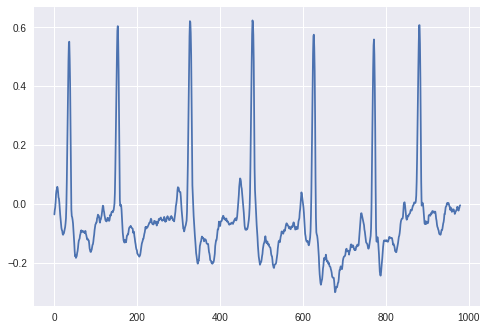

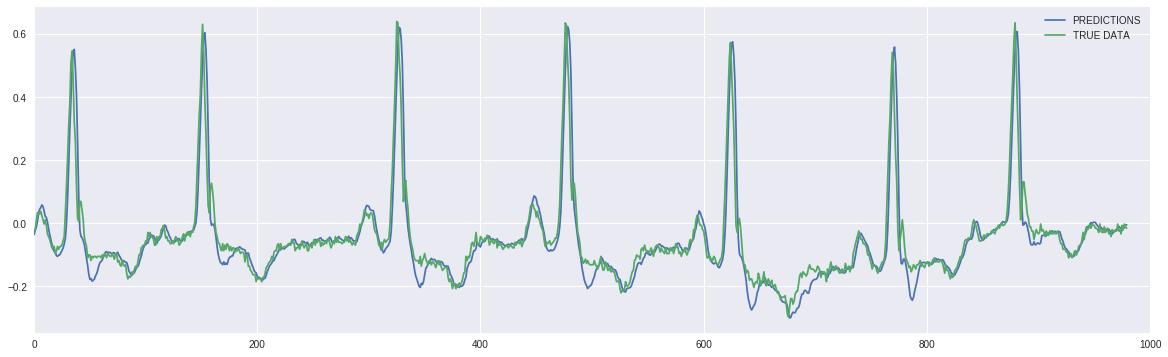

In [23]:
out_sample.shape
out_values = series_to_supervised(data = out_sample.reshape(-1,1), n_in = 20, n_out = 1, dropnan = True)
out_values = np.asarray(out_values)
testY = out_values[:,-1]
print(testY.shape) #doe sthis match the test_preds shape 
testX = out_values[:,:-1]
testX = np.expand_dims(testX, axis = 1)
print(testX.shape)  #this is the size of the test X should be something like 980, 1, 20
predictions = model.predict(testX, batch_size = 1)
print(predictions.shape)
summed = np.sum(predictions, axis = -1); print(summed.shape)
test_preds = summed[:,0]
plt.plot(test_preds); print(test_preds.shape) #does this match the testY.shape
print("Final R2 Score is: {}".format(r2_score(testY, test_preds)))

fig = plt.figure(figsize = (20,6))
fig = plt.plot(test_preds, label = "PREDICTIONS")
fig = plt.plot(testY, label = "TRUE DATA")
plt.xlim([0,1000])
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()